In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
import numpy as np
import pandas as pd

In [2]:
def make_data(N,f=0.3,rseed=1):
    rand=np.random.RandomState(rseed)
    x=rand.randn(N)
    x[int(f*N):]+=5
    return x
x=make_data(1000)

In [4]:
data=pd.read_csv("mfa_2019_07_03_TRIPLEX_16_probe_concentration_A03_Amplitude.csv")
#data=pd.read_csv("mfa_12_6_2018_hpv_A10_Amplitude.csv")
data.dropna(axis=0,how='all')  
X=data.iloc[:,0]#Amplitude data

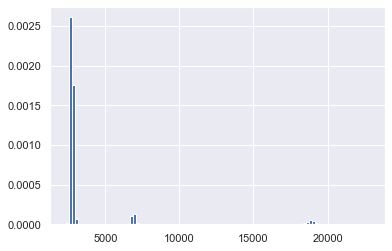

In [5]:
hist=plt.hist(X,bins=100,density=True)

In [8]:
# choose bandwidth (cross validation)

from sklearn.neighbors import KernelDensity
'''
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
bd=10**np.linspace(1,3.6,50)
grid=GridSearchCV(KernelDensity(kernel='gaussian'),
                  {'bandwidth':bd},
                  
                  )
grid.fit(X[:,None]);
bd=grid.best_params_['bandwidth']

print(bd)'''

"\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.model_selection import LeaveOneOut\nbd=10**np.linspace(1,3.6,50)\ngrid=GridSearchCV(KernelDensity(kernel='gaussian'),\n                  {'bandwidth':bd},\n                  \n                  )\ngrid.fit(X[:,None]);\nbd=grid.best_params_['bandwidth']\n\nprint(bd)"

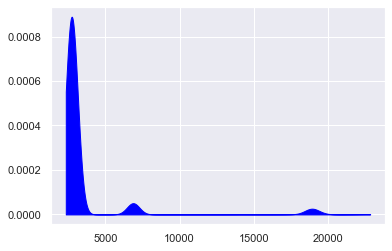

In [10]:
#initialize and fit the KDE model
kde=KernelDensity(bandwidth=400,kernel='gaussian')
kde.fit(X[:,None])
#score_samples return the density's logarithm
X_d=np.linspace(min(X),max(X),len(X))
logprob=kde.score_samples(X_d[:,None])

plt.fill_between(X_d,np.exp(logprob),edgecolor='blue',fc='blue')
d=np.exp(logprob)
#plt.plot(X,np.full_like(X,0),'|k',markeredgewidth=0.1)
#Overfitting using bd

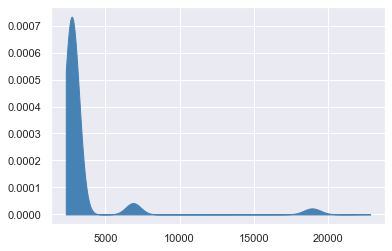

In [11]:
#use scipy.stats.gaussian_kde to plot
import scipy.stats as scis
KDE=scis.gaussian_kde(X,bw_method='silverman')
X_d=np.linspace(min(X),max(X),len(X))
d=KDE(X_d)
plt.fill_between(X_d,d,edgecolor='steelblue',fc='steelblue')

In [ ]:
#add a div None/True here.
div=100
#ask how many peaks do u want to detect?
#ask for threshold
#calculate rain

In [12]:
#find peaks_1_ use a function offered by scipy
import scipy.signal as sci
peaks,prop=sci.find_peaks(d,height=0.001*max(d),distance=20)
temp=np.ones(len(peaks),dtype=int)
pks_cddt=np.vstack((X_d[peaks],d[peaks],temp,peaks))
pks_cddt

array([[2.71971122e+03, 6.86848836e+03, 1.89503683e+04, 2.26200175e+04],
       [7.32865269e-04, 4.21842514e-05, 2.24326908e-05, 7.51076568e-07],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [2.54000000e+02, 2.89500000e+03, 1.05860000e+04, 1.29220000e+04]])

In [13]:
#find the weak signals, merge the strong signals
for i in range(0,len(peaks)-1):
    j=i+1
    while j<len(peaks) and abs(pks_cddt[0,i]-pks_cddt[0,j])<2000:
        if pks_cddt[1,i]<pks_cddt[1,j]:
            pks_cddt[2,i]=0
        else:
            pks_cddt[2,j]=0
        j+=1
#b= a[np.where((a[:,0]>0) & (a[:,0]<6))]
pks=pks_cddt[:,np.where(pks_cddt[2,:]==1)]
peaks=np.array(pks[3],dtype=int).flatten()
peaks

array([  254,  2895, 10586, 12922])

In [14]:
#find peaks_2(define a function)

def fp(X,d,bw=20):
    p=np.zeros(10000,dtype='int16')#will store the index of peaks
    count=0
    for i in range(1,len(X)):
        start=i-bw
        end=i+bw
        if start<0:
            start=0
        if end>len(X)-1:
            end=len(X)-1
        if d[i]>=max(d[start:i+1]) and d[i]>=max(d[i:end+1]):
            p[count]=i
            count+=1
    return p[0:count],X[p[0:count]],d[p[0:count]]#return index of peaks, Amplitude of peaks and density of peaks
index,peaks_2,pdensity=fp(X,d)
peaks_2

254       2572.49341
2895      2658.19727
7650      2743.50732
10586     2831.28613
12922    19063.14840
Name: Ch1 Amplitude, dtype: float64

In [15]:
#remove the peaks lower than 1/n of maximium height
def rp(p,d,n=100):
    dm=max(d)/n
    p=p[d[p]>dm]
    return p
rp(index,d)

array([  254,  2895, 10586], dtype=int16)

In [16]:

#find width
wid,hei,left,right=sci.peak_widths(d,peaks,rel_height=1)
print(wid,hei)

[ 508.7335735  2385.0960086  2750.09132012  332.94209188] [5.30085605e-04 7.64754283e-08 1.57274064e-07 6.83966309e-07]


In [17]:
for i in range(len(peaks)-1):
    R=(X_d[peaks[i+1]]-X_d[peaks[i]])/(0.5*(wid[i]+wid[i+1]))
    print("R",i+1,'=',R)


R 1 = 2.8673265111037094
R 2 = 4.7055264741878435
R 3 = 2.3805445202841735
